In [2]:
import pandas as pd
import numpy as np
# UNCOMMENT LINE BELOW IF SERVER DOESN'T HAVE BIO 
# !pip install biopython
from Bio import SeqIO
import re
import itertools
# from google_drive_downloader import GoogleDriveDownloader as gdd
import cProfile
from urllib.request import urlretrieve
import time

In [2]:
# data import
# bio_sample_data_gdd_id = '1hqDeH_JgND_PY0DX_sFfUQcAuZXoQbAA'

# gdd.download_file_from_google_drive(file_id=bio_sample_data_gdd_id,
#                                     dest_path='./bio_sampledata.txt',
#                                     unzip=False)
# urlretrieve("https://pastebin.com/raw/MZfiRmT6", './bio_sampledata.txt')

fasta_file = './bio_sampledata.txt'

# !head ./bio_sampledata.txt


In [3]:
def read_fasta(filename):
  descriptor_line_pattern = re.compile(">([\w|\.]*) ([\w|\s|\:|\(|\)|\-]*) \[(.*)\]")

  with open(filename, 'r') as file:
    records = []

    id = None
    enzyme = None
    species = None
    genetic_data = ''

    for line in file.readlines():
      if line[0] == '>':
        if id is not None:
          records.append([id, enzyme, species, genetic_data])
        match = descriptor_line_pattern.match(line)
        if match is None:
          print('HELP', line)
          return
        id = match.group(1)
        enzyme = match.group(2)
        species = match.group(3)
        genetic_data = ''
      else:
        genetic_data += line.strip()
    records.append([id, enzyme, species, genetic_data, []])

  return pd.DataFrame(records, columns=['ID', 'Enzyme', 'Species', 'Genes', 'Heatmap'])

        
data = read_fasta(fasta_file)
data.head()

,ID,Enzyme,Species,Genes,Heatmap
0,WP_132583182.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. D18,MRVIKLSALTLLSLFATTLNATPALSDLKLEQSITLSGLSSGAYMA...,None
1,WP_068238279.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. EpRS3,MHKLKLSSFTLLSAVTLPLAAQQALPKLQLAEQITLSGLSSGAYMA...,None
2,PKM21193.1,polyhydroxybutyrate depolymerase,Gammaproteobacteria bacterium HGW-Gammaproteob...,MRTFKLFSFTLLSAVTLPLAAQQALPKLQLAEQITLSGLSSGAYMA...,None
3,WP_215397783.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. GL-53,MPKLKLVSFTLLSVFALPLTAELTLPKLQLAEQITLSGLSSGAYMA...,None
4,MBJ92526.1,polyhydroxybutyrate depolymerase,Alteromonadaceae bacterium,MRFVTLTVLLLSAPSPFTLANNNSAISTLNLDETITVSGLSSGAYM...,None


In [4]:
data.iloc[0]['Genes']

'MRVIKLSALTLLSLFATTLNATPALSDLKLEQSITLSGLSSGAYMAGQYHVAFAEQVDGVAMLASGPVYCAQNSLGLALEHCFNKDTSAPDILAIKQYIAAQRSAGKLAPLITLKDDKIWIFHGAKDATVQPKLATILYEQYKQWVTPENIVLINDKPFAHTFPTDRPNLGSCERSEAPYLASCGYDASGSLLQHLLGKVKAKTTSTTGTLLEINQHQLAAAAKDTLAEIGYLYVPVSCAAGEPCKLHVSFHGCKQNANSVGDAFVTGTDLNNYADTNNLVIFYPQTVASSINPFNPNACWDWWGYTGADYATKTGPQLQAVHQLVQALLP'

In [5]:
# load scoring matrix
url = 'https://www.ncbi.nlm.nih.gov/Class/FieldGuide/BLOSUM62.txt'
blosum62 = pd.read_csv(url, skiprows=6, delim_whitespace=True, index_col=0)
blosum62['-'] = blosum62['*']
blosum62.head()

,A,R,N,D,C,Q,E,G,H,I,...,S,T,W,Y,V,B,Z,X,*,-
A,4,-1,-2,-2,0,-1,-1,0,-2,-1,...,1,0,-3,-2,0,-2,-1,0,-4,-4
R,-1,5,0,-2,-3,1,0,-2,0,-3,...,-1,-1,-3,-2,-3,-1,0,-1,-4,-4
N,-2,0,6,1,-3,0,0,0,1,-3,...,1,0,-4,-2,-3,3,0,-1,-4,-4
D,-2,-2,1,6,-3,0,2,-1,-1,-3,...,0,-1,-4,-3,-3,4,1,-1,-4,-4
C,0,-3,-3,-3,9,-3,-4,-3,-3,-1,...,-1,-1,-2,-2,-1,-3,-3,-2,-4,-4


In [6]:
def matrix(a, b, gap_cost=4):
    H = np.zeros((len(a) + 1, len(b) + 1), int)
    for i, j in itertools.product(range(1, H.shape[0]), range(1, H.shape[1])):
        match = H[i - 1, j - 1] + blosum62.loc[a[i-1], b[j-1]] #Line causing an index error, split above to see which part is caising error
        delete = H[i - 1, j] - gap_cost
        insert = H[i, j - 1] - gap_cost
        H[i, j] = max(match, delete, insert, 0)

    return H

def traceback(H, b, b_='', old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmax(), H_flip.shape)
    i, j = np.subtract(H.shape, (i_ + 1, j_ + 1))  # (i, j) are **last** indexes of H.max()
    if H[i, j] == 0:
        return b_, j
    b_ = b[j - 1] + '-' + b_ if old_i - i > 1 else b[j - 1] + b_
    return traceback(H[0:i, 0:j], b, b_, i)

def smith_waterman(a, b, gap_cost=4):
    # a, b = a.upper(), b.upper()
    H = matrix(a, b, gap_cost)
    b_, pos = traceback(H, b)
    return pos, pos + len(b_)

In [7]:
# a = data.iloc[0]['Genes']
# b = data.iloc[1]['Genes']
# matrix(a,b)
# print(smith_waterman(a, b))
# print(smith_waterman(b, a))
# cProfile.run('smith_waterman(a, b)')
# cProfile.run('matrix(a, b)')

In [30]:
# cache is outside of function to allow for errors
cache = {}

In [36]:
def generate_heatmap(df):
  # cache each comparison - so we only do each comparison once
  # cache = {}
  for i, enzyme in df[pd.isnull(df['Heatmap'])].iterrows():
    print(f'{enzyme["Enzyme"]} - {i} / {len(df)}')
    # init empty heatmap
    length = len(enzyme['Genes'])
    heatmap = np.zeros(length, int)
    # compare with every other enzyme
    for j, compare in df.iterrows():
      # skip same comparison
      if i == j:
        continue

      local_alignment = None
      # check if we've already done this alignment
      if (j,i) in cache:
        # print('FOUND IN CACHE')
        local_alignment = cache[(j,i)]
      elif (i,j) in cache:
        local_alignment = cache[(i,j)]
      else:
        # align comparison
        local_alignment = smith_waterman(enzyme['Genes'], compare['Genes'])
        # add comparison to cache
        cache[(i, j)] = local_alignment
      # update heatmap
      for hit in range(local_alignment[0], min(length-1,local_alignment[1])):
        heatmap[hit] += 1 

    # add heatmap to dataframe
    df.iloc[i]['Heatmap'] = heatmap


generate_heatmap(data)
data.to_pickle(f'./heatmap_generated_{fasta_file}_{time.strftime("%Y%m%d-%H%M%S")}.pickle')
data.head()

polyhydroxybutyrate depolymerase - 22 / 100
polyhydroxybutyrate depolymerase - 23 / 100
polyhydroxybutyrate depolymerase - 24 / 100
polyhydroxybutyrate depolymerase - 25 / 100
polyhydroxybutyrate depolymerase - 26 / 100
polyhydroxybutyrate depolymerase - 27 / 100
polyhydroxybutyrate depolymerase - 28 / 100
polyhydroxybutyrate depolymerase - 29 / 100
polyhydroxybutyrate depolymerase - 30 / 100
polyhydroxybutyrate depolymerase - 31 / 100
polyhydroxybutyrate depolymerase - 32 / 100
polyhydroxybutyrate depolymerase - 33 / 100
polyhydroxybutyrate depolymerase - 34 / 100
polyhydroxybutyrate depolymerase - 35 / 100
polyhydroxybutyrate depolymerase - 36 / 100
polyhydroxybutyrate depolymerase - 37 / 100
polyhydroxybutyrate depolymerase - 38 / 100
polyhydroxybutyrate depolymerase - 39 / 100
prolyl oligopeptidase family serine peptidase - 40 / 100
polyhydroxybutyrate depolymerase - 41 / 100
polyhydroxybutyrate depolymerase - 42 / 100
poly(3-hydroxybutyrate) depolymerase - 43 / 100
prolyl oligopep

,ID,Enzyme,Species,Genes,Heatmap
0,WP_132583182.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. D18,MRVIKLSALTLLSLFATTLNATPALSDLKLEQSITLSGLSSGAYMA...,"[78, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9..."
1,WP_068238279.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. EpRS3,MHKLKLSSFTLLSAVTLPLAAQQALPKLQLAEQITLSGLSSGAYMA...,"[78, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9..."
2,PKM21193.1,polyhydroxybutyrate depolymerase,Gammaproteobacteria bacterium HGW-Gammaproteob...,MRTFKLFSFTLLSAVTLPLAAQQALPKLQLAEQITLSGLSSGAYMA...,"[78, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9..."
3,WP_215397783.1,polyhydroxybutyrate depolymerase,Rheinheimera sp. GL-53,MPKLKLVSFTLLSVFALPLTAELTLPKLQLAEQITLSGLSSGAYMA...,"[77, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 9..."
4,MBJ92526.1,polyhydroxybutyrate depolymerase,Alteromonadaceae bacterium,MRFVTLTVLLLSAPSPFTLANNNSAISTLNLDETITVSGLSSGAYM...,"[78, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9..."


In [14]:
data = pd.read_pickle('heatmap_generated_uniprot_keyword_search.fasta_20211106-131321.pickle')
data.head()

,ID,Enzyme,Species,Genes,Heatmap
0,>sp|A9GMG8|CE1_SORC5 Multifunctional esterase ...,None,None,MDQFKTHVLGLASLSLALLVALPARGASLQKVNQSEWGADGLPSYV...,"[169, 169, 169, 169, 172, 172, 173, 173, 173, ..."
1,>sp|P12625|PHB_RALPI Poly(3-hydroxybutyrate) d...,None,None,MVRRLWRRIAGWLAACVAILCAFPLHAATAGPGAWSSQQTWAADSV...,"[168, 168, 169, 169, 169, 169, 170, 170, 170, ..."
2,>sp|P52090|PHA1_PAULE Poly(3-hydroxyalkanoate)...,None,None,MLAKQIKKANSRSTLLRKSLLFAAPIILAVSSSSVYALTQVSNFGT...,"[171, 171, 171, 171, 171, 172, 173, 173, 173, ..."
3,>sp|P26495|PHAZ_PSEOL Poly(3-hydroxyalkanoate)...,None,None,MPQPYIFRTVELDNQSIRTAVRPGKPHLTPLLIFNGIGANLELVFP...,"[166, 166, 167, 167, 168, 169, 170, 170, 170, ..."
4,">tr|A0A0N0NC74|A0A0N0NC74_9ACTN Esterase, PHB ...",None,None,MRPGLSTQTGATRRAADSLSRTPRTTSPEPLPERDKRVSNSPGRAL...,"[173, 173, 173, 173, 173, 173, 173, 173, 173, ..."


In [15]:
max_length = max([len(h) for h in data['Heatmap']])

In [16]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

In [17]:
normalized_heatmap = np.zeros((len(data), max_length))

for row_index, row in enumerate(list(data['Heatmap'])):
    for h_index, h in enumerate(row):
        normalized_heatmap[row_index, h_index] = h / 100.0

# normalized_heatmap = np.stack(data['Heatmap'], axis='None')

print(normalized_heatmap)
# fullprint(normalized_heatmap)

[[1.69 1.69 1.69 ... 0.   0.   0.  ]
 [1.68 1.68 1.69 ... 0.   0.   0.  ]
 [1.71 1.71 1.71 ... 0.   0.   0.  ]
 ...
 [1.73 1.73 1.73 ... 0.   0.   0.  ]
 [1.73 1.73 1.73 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

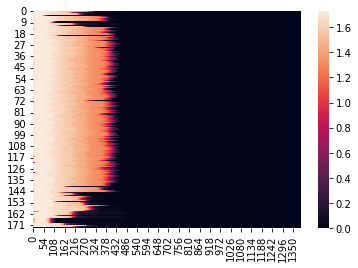

In [19]:
sns.heatmap(normalized_heatmap)
plt.show()